# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Семинар 13. CLIP`

### `Материалы составили Оганов Александр (@welmud)`

#### `Москва, Весенний семестр 2025`

`Материалы`

- [Статья CLIP](https://arxiv.org/abs/2103.00020)
- [Официальная реализация](https://github.com/openai/CLIP)
- Часть примеров взята [из источника](https://medium.com/@kerry.halupka/getting-started-with-openais-clip-a3b8f5277867)
- [Contrastive Representation Learning](https://lilianweng.github.io/posts/2021-05-31-contrastive/)


In [1]:
def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

## `CLIP`

Сегодня мы подробно рассмотрим модель CLIP, предложенную в работе Learning Transferable Visual Models From Natural Language Supervision, [Alec Radford et al., 2021](https://arxiv.org/abs/2103.00020), примерно 33 тысячи цитат.

На лекции мы обсуждали мультимодальные модели, то есть модели, которые могут строить векторные представления как для изображений, так и для текста. Если мы умеем строить эмбеддинги, то как мы их можем использовать?

Кажется разумным, что стоит взять текст и изображение. Построить для них эмбеддинги и вычислить между ними расстояние. Если эмбеддинги близки, то текст и изображения похожи.

Отдельная и достаточная трудная задача: как собрать достаточно большой датасет? Подробное обсуждние этой проблемы есть в [секции 2.2](https://arxiv.org/abs/2103.00020). Допустим, у нас уже есть достаточно большой датасет изображений и текстовых описаний к ним. Как обучать модель?

Чтобы разобраться как задать функцию потерь, надо понять чего именно мы хотим?

Мы хотим от модели:
- Изображение и описание к нему имели "близкие" эмбеддинги;
- Изображение и текст, не совпадающий с его описанием, имели "далекие" эмбеддинги.

Тем самым мы хотим, чтобы "правильные" объекты были "близки", а "неправильные" — нет. Такой подход к обучению называется `Contrastive Learning`, эту идею вы уже встречали в классическом машинном обучении.

Авторы предлагают использовать следующий подход к обучению:

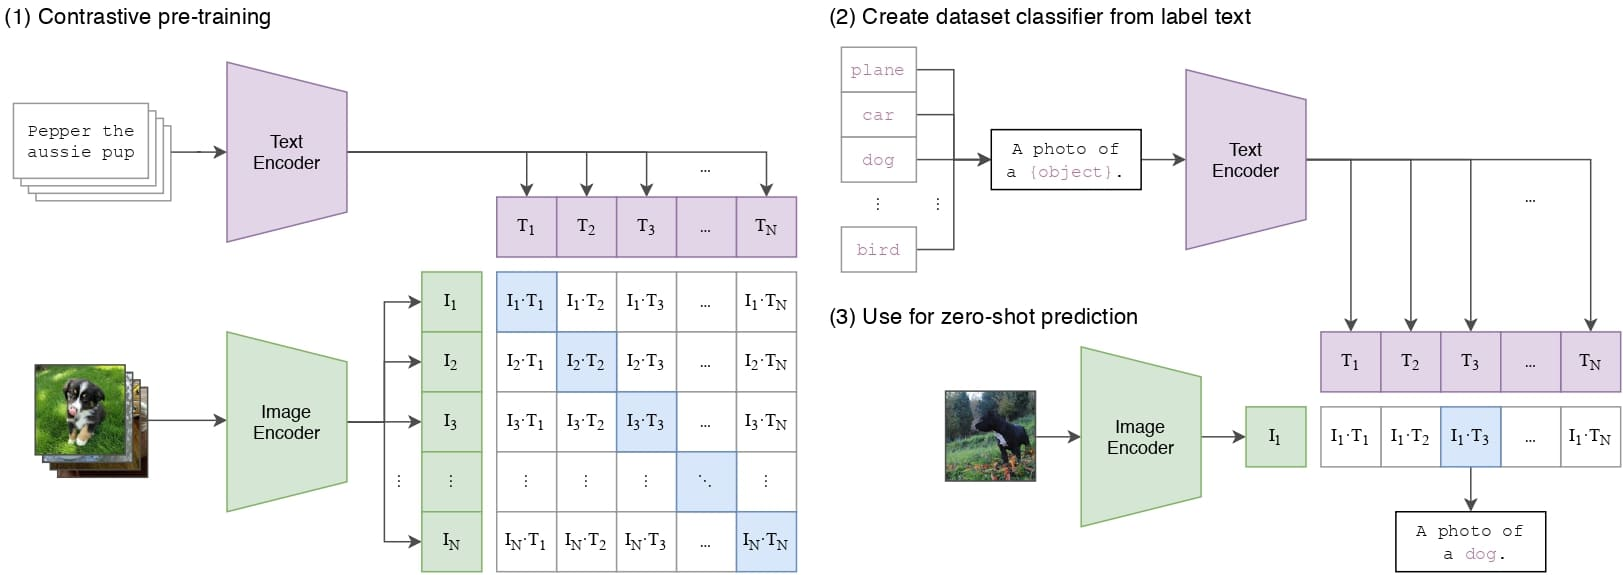

Тогда лосс можно записать так:

```python
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter
# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]
# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)
# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```

In [2]:
import requests
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, CIFAR100

from transformers import CLIPProcessor, CLIPModel
from diffusers import DiffusionPipeline

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:482: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:339: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2025-04-22 13:42:14.940397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one

## `Zero-shot`

Обычно, когда мы решаем задачу классификации, у нас есть обучающая выборка. Иногда, мы решаем задачу, когда примеров изображений каждого класса очень мало и чаще всего мы дообучаем модель (finetuning). 

Также существует **Zero-shot** постановка:

Обучение без выборки, кроме того, модель не знает о том, какие классы существуют.

CLIP предварительно обучен предсказывать, совпадают ли изображение и фрагмент текста. Для выполнения классификации в постановке **Zero-shot** мы воспользуемся этим свойством. Для каждого набора данных мы используем
названия всех классов в наборе данных в качестве набора потенциальных текстовых пар и прогнозируем наиболее вероятную пару (изображение, текст) в соответствии с CLIP.

На практике часто используют официальную реализацию [GitHub](https://github.com/openai/CLIP), но для удобства мы будем использовать Hugging Face.

In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Посмотрим на предобработку изображений. Что вы можете в ней заметить важного?

In [9]:
processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [10]:
IMAGE_MEAN = torch.tensor(processor.image_processor.image_mean)
IMAGE_STD  = torch.tensor(processor.image_processor.image_std)

Также полезно посмотреть на число параметров модели, чтобы понимать насколько вычислительно трудно её использовать.

In [12]:
print_params_count(model)

Информация о числе параметров модели: CLIPModel
Всего параметров: 		 151277313
Всего обучаемых параметров: 	 151277313



### `MS-COCO`


Посмотрим, как работает подход на датасете [MS-COCO](https://cocodataset.org/#home), в котором содержаться изображения и описания к ним.

In [13]:
def vis_img(img, ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.axis('off')

    if ax is None:
        plt.tight_layout()
        plt.show()

In [17]:
image_url = 'http://images.cocodataset.org/val2014/COCO_val2014_000000159977.jpg'

content = requests.get(image_url, stream=True).raw
image   = Image.open(content)

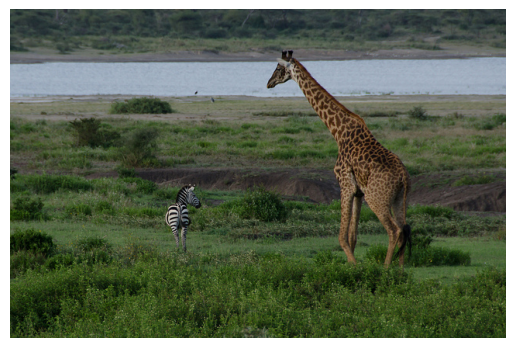

In [18]:
vis_img(image)

Посмотрим как преобразования CLIP влияют на изображение.

In [25]:
inputs = processor(images=image, return_tensors="pt", padding=True)
inputs.keys()

dict_keys(['pixel_values'])

In [26]:
image_processor = inputs['pixel_values']
image_processor.shape

torch.Size([1, 3, 224, 224])

In [27]:
def inverse_transform(image_tensor):
    if len(image_tensor.shape) == 4:
        image_tensor = image_tensor[0]

    image = image_tensor * IMAGE_STD[:, None, None] + IMAGE_MEAN[:, None, None]

    image = image.permute(1, 2, 0).detach().cpu().numpy()
    return image


In [28]:
image_inverse = inverse_transform(image_processor)

In [29]:
np.array(image).shape, image_inverse.shape

((424, 640, 3), (224, 224, 3))

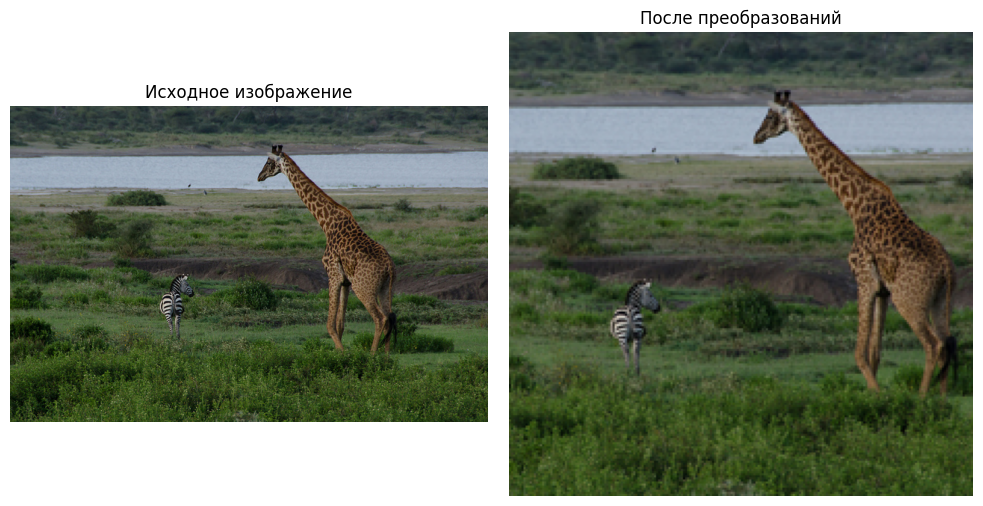

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("Исходное изображение")
vis_img(image, ax[0])

ax[1].set_title("После преобразований")
vis_img(image_inverse, ax[1])

plt.tight_layout()
plt.show()

Попробуем определить, что есть на изображении.

In [32]:
text=["a photo of a cat", "wildlife", "a photo of a zebra", "a photo of a cake", "a photo of a giraffe"]

text_processor = processor(text=text, return_tensors="pt", padding=True)

In [33]:
text_processor

{'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407],
        [49406,  5250, 49407, 49407, 49407, 49407, 49407],
        [49406,   320,  1125,   539,   320, 22548, 49407],
        [49406,   320,  1125,   539,   320,  2972, 49407],
        [49406,   320,  1125,   539,   320, 22826, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1]])}

In [34]:
outputs = model(
    input_ids      = text_processor['input_ids'],
    attention_mask = text_processor['attention_mask'],
    pixel_values   = image_processor
)

In [35]:
outputs.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

In [36]:
def print_clip_res(probs, text):
    probs = probs.detach().cpu().ravel().numpy()

    p_args_sort = np.argsort(probs)[::-1]
    for i in p_args_sort:
        print(f"Вероятность = {probs[i]:0.5f}")
        print(f"Текст = {text[i]}\n")


In [37]:
probs = outputs.logits_per_image.softmax(dim=1)
probs

tensor([[4.4708e-05, 1.0181e-01, 2.6256e-01, 3.6088e-05, 6.3555e-01]],
       grad_fn=<SoftmaxBackward0>)

In [38]:
print_clip_res(probs, text)

Вероятность = 0.63555
Текст = a photo of a giraffe

Вероятность = 0.26256
Текст = a photo of a zebra

Вероятность = 0.10181
Текст = wildlife

Вероятность = 0.00004
Текст = a photo of a cat

Вероятность = 0.00004
Текст = a photo of a cake



Тоже самое можно сделать в одну строчку.

In [40]:
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

### `CIFAR10`

Померим качество на знакомом вам `CIFAR10`.

In [41]:
# Download the dataset
cifar10 = CIFAR10(root="./", download=True, train=False)

Files already downloaded and verified


In [42]:
image, class_id = cifar10[317]

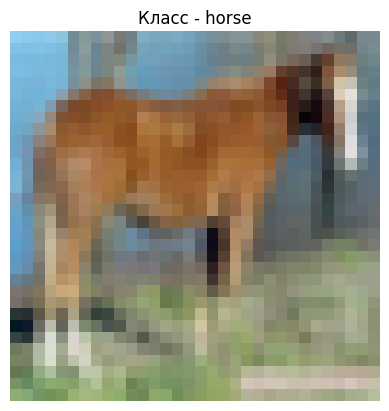

In [43]:
fig, ax = plt.subplots(1, 1)

ax.set_title(f"Класс - {cifar10.classes[class_id]}")
vis_img(image, ax=ax)

In [44]:
text_inputs = [f"a photo of a {c}" for c in cifar10.classes]

In [45]:
inputs = processor(text=text_inputs, images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

In [46]:
print_clip_res(probs, text_inputs)

Вероятность = 0.99269
Текст = a photo of a horse

Вероятность = 0.00255
Текст = a photo of a dog

Вероятность = 0.00136
Текст = a photo of a deer

Вероятность = 0.00124
Текст = a photo of a cat

Вероятность = 0.00116
Текст = a photo of a bird

Вероятность = 0.00053
Текст = a photo of a automobile

Вероятность = 0.00025
Текст = a photo of a ship

Вероятность = 0.00011
Текст = a photo of a airplane

Вероятность = 0.00010
Текст = a photo of a truck

Вероятность = 0.00001
Текст = a photo of a frog



In [47]:
cifar10 = CIFAR10(root="./", download=True, train=False, transform=processor.image_processor)
cifar10_dataloader = DataLoader(
    cifar10,
    batch_size=500,
    shuffle=False,
    drop_last=False
)

Files already downloaded and verified


In [48]:
def predict_clip_zeroshot(dataloader, text_inputs):

    y_true = []
    y_pred = []

    inputs = processor(text=text_inputs, return_tensors="pt", padding=True)
    for k, v in inputs.items():
        inputs[k] = v.to(device)

    for X_batch, y_batch in tqdm(dataloader, total=len(dataloader)):
        X_batch = X_batch['pixel_values'][0].to(device)


        with torch.no_grad():
            outputs = model(
                input_ids      = inputs['input_ids'],
                attention_mask = inputs['attention_mask'],
                pixel_values   = X_batch
            )
            logits_per_image = outputs.logits_per_image
            class_pred = logits_per_image.argmax(dim=1)


        y_pred += class_pred.detach().cpu().tolist()
        y_true += y_batch

    return np.array(y_true), np.array(y_pred)


In [49]:
model = model.to(device)

In [50]:
y_true, y_pred = predict_clip_zeroshot(cifar10_dataloader, text_inputs)

100%|█████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.41s/it]


In [51]:
accuracy = np.mean(y_true == y_pred)

print(f"Accuracy = {accuracy:.3f}")

Accuracy = 0.888


### `CIFAR100`

Рассмотрим более сложный датасет, например, `CIFAR100`, в котором содержится 100 разных классов.

In [52]:
cifar100 = CIFAR100(root="./", download=True, train=False, transform=processor.image_processor)
cifar100_dataloader = DataLoader(
    cifar100,
    batch_size=500,
    shuffle=False,
    drop_last=False
)

text_inputs = [f"a photo of a {c}" for c in cifar100.classes]

Files already downloaded and verified


In [53]:
y_true, y_pred = predict_clip_zeroshot(cifar100_dataloader, text_inputs)

100%|█████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]


In [54]:
accuracy = np.mean(y_true == y_pred)

print(f"Accuracy = {accuracy:.3f}")

Accuracy = 0.617


## `Linear-probe evaluation`

Обучим теперь линейный классификатор поверх фичей полученных из CLIP. Обучение линейной модели поверх эмбеддингов модели называется `Linear-probe`.

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [56]:
@torch.no_grad()
def get_features(dataset):
    all_features = []
    all_labels = []

    for images, labels in tqdm(DataLoader(dataset, batch_size=500)):
        features = model.get_image_features(
            pixel_values=images['pixel_values'][0].to(device)
        )

        all_features.append(features)
        all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [57]:
cifar100 = CIFAR100(root="./", download=True, train=False, transform=processor.image_processor)

Files already downloaded and verified


In [58]:
features, labels = get_features(cifar100)

100%|█████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


In [59]:
train_features, val_features, train_labels, val_labels = train_test_split(
    features,
    labels,
    test_size=0.2,
    shuffle=True,
    random_state=0
)

train_features.shape, val_features.shape

((8000, 512), (2000, 512))

In [60]:
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60517D+00    |proj g|=  1.46854D-02

At iterate   50    f=  7.24917D-01    |proj g|=  8.31674D-03

At iterate  100    f=  7.03950D-01    |proj g|=  1.43818D-03

At iterate  150    f=  7.03468D-01    |proj g|=  2.85171D-04

At iterate  200    f=  7.03267D-01    |proj g|=  8.67976D-04

At iterate  250    f=  7.02246D-01    |proj g|=  4.46789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
51300    279    286      1     0     0   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.3s finished


LogisticRegression(C=0.316, max_iter=1000, random_state=0, verbose=1)

In [61]:
predictions = classifier.predict(val_features)
accuracy = np.mean((predictions == val_labels).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 75.050


## `Нейронные метрики оценки качества`

На паре по `GAN` мы впервые познакомились с задачей генеративного моделирования, в частности научились генерировать изображения. 

Когда мы решаем какую-либо задачу нам важно понимать какие метрики нам важны и что действительно отражает качество?

### `FID`

Наша цель, чтобы распределение реальных данных было похоже на распределение сгенерированных данных. В случае изображений это сделать достаточно трудно, но давайте начнем с простого:

Как измерить похожесть между двумя нормальными распределениями? Использовать расстояние Фреше

$$
\textbf{FID} = \mathcal{W}_{2}(\mathcal{N}(\mu_{A}, \Sigma_{A}), \mathcal{N}(\mu_{B}, \Sigma_{B})) = ||\mu_{A} - \mu_{B}||_{2}^{2} + \text{Tr}\Big( \Sigma_{A} + \Sigma_{B} - 2 \sqrt{\Sigma_{A} \Sigma_{B}} \Big)
$$

Прада есть проблема, мы рассматриваем распределения изображений, а оно не является нормальным. 

Вопрос: Как мы могли бы получить нормальное распределение по выборке?

Мы могли бы усреднить все изображения и мы знаем, что среднее по ЦПТ похоже на нормальное распределение, также могли бы оценить матрицу ковариации. К сожалению, в пространстве изображений у нас высокая размерность и "слишком сложное" распределение?

Вопрос: Как решить эту проблему?

Ответ: Использовать пространство в котором структура сильно проще, например, латетное пространство классификатора. Обычно используют модель `Inception-V3` и фичи с определенного слоя.

После чего считают математическое ожидание и матрицу ковариций в латетном пространстве. Теперь мы сможем измерить расстояние Фреше в латетном пространстве модели `Inception-V3`.

Данная метрика называется `Fréchet inception distance (FID)`. Обычно для стабильной оценки статистик в латетном пространстве необходимо 50 тысяч сгенерированных изображений.

### `CLIP score`

Как мы можем оценить text-to-image генерацию? Что мы хотим от сгенерированных изображений?

Наша цель, чтобы изображение, полученное по тексту, было бы похоже на этот текст. Для вычисления похожести мы можем использовать CLIP, данная метрика работает для пары: текст, изображение.


In [62]:
def calc_clip_score(inputs):

    image_features = model.get_image_features(inputs['pixel_values'])
    image_features = image_features / image_features.norm(dim=1, keepdim=True).to(torch.float32)

    text_features = model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    text_features = text_features  / text_features.norm(dim=1, keepdim=True).to(torch.float32)

    return (image_features * text_features).sum(1)

В качестве метода генерации изображений по тексту мы будем использовать диффузионную модель `SDXL`.

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

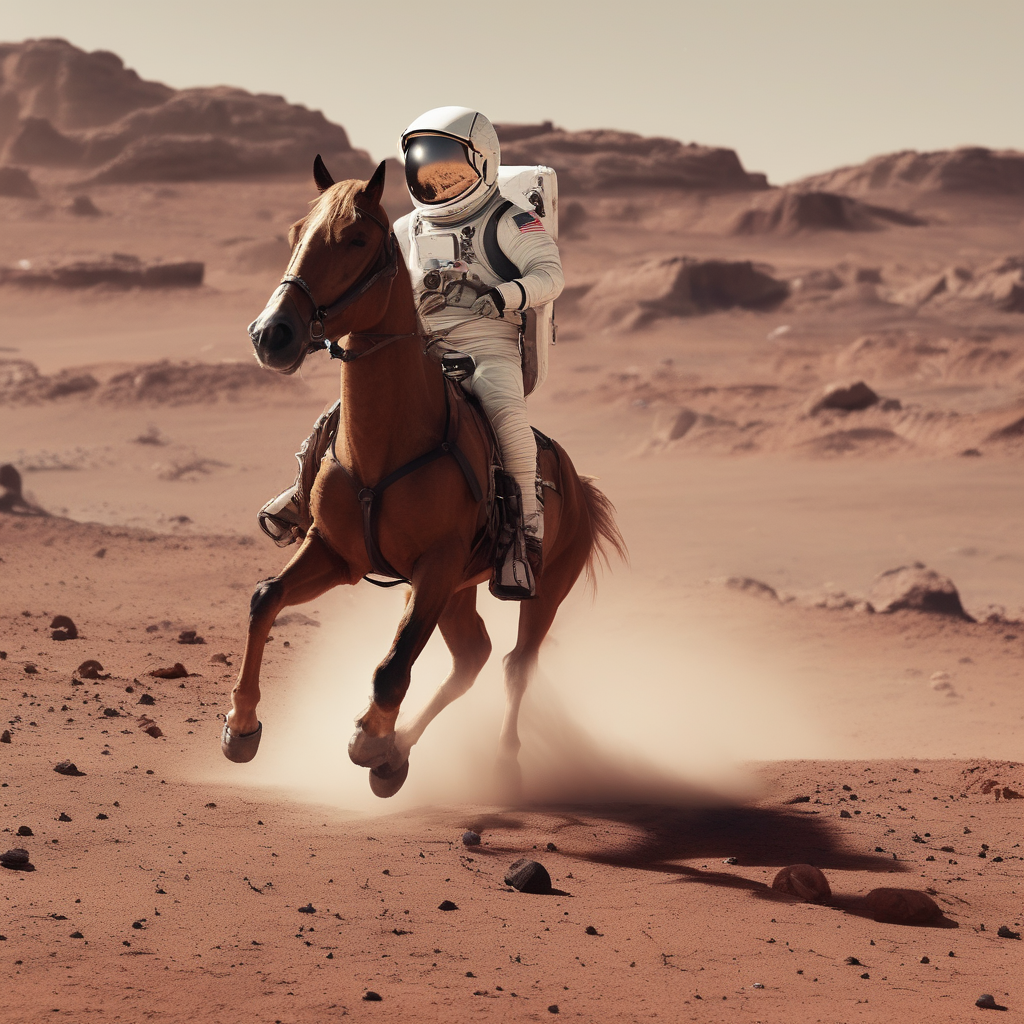

In [ ]:
image

Генерация по тексту является задачей условной генерации, а за силу влияния условия на результат отвечает `guidance_scale`, который обычно равен 7.5. 

In [ ]:
def generate_img(guidance_scale=7.5):
    generator = torch.Generator()
    generator.manual_seed(42)

    image = pipe(prompt, guidance_scale=guidance_scale, generator=generator).images[0]

    return image

g_grid = [1, 2, 5, 7.5, 10, 15, 20, 40]

Для начала проверим как ведет себя метрика при простом промте, то есть когда изображение простое.

In [ ]:
prompt = "A horse"

In [ ]:
images = list(generate_img(g) for g in g_grid)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

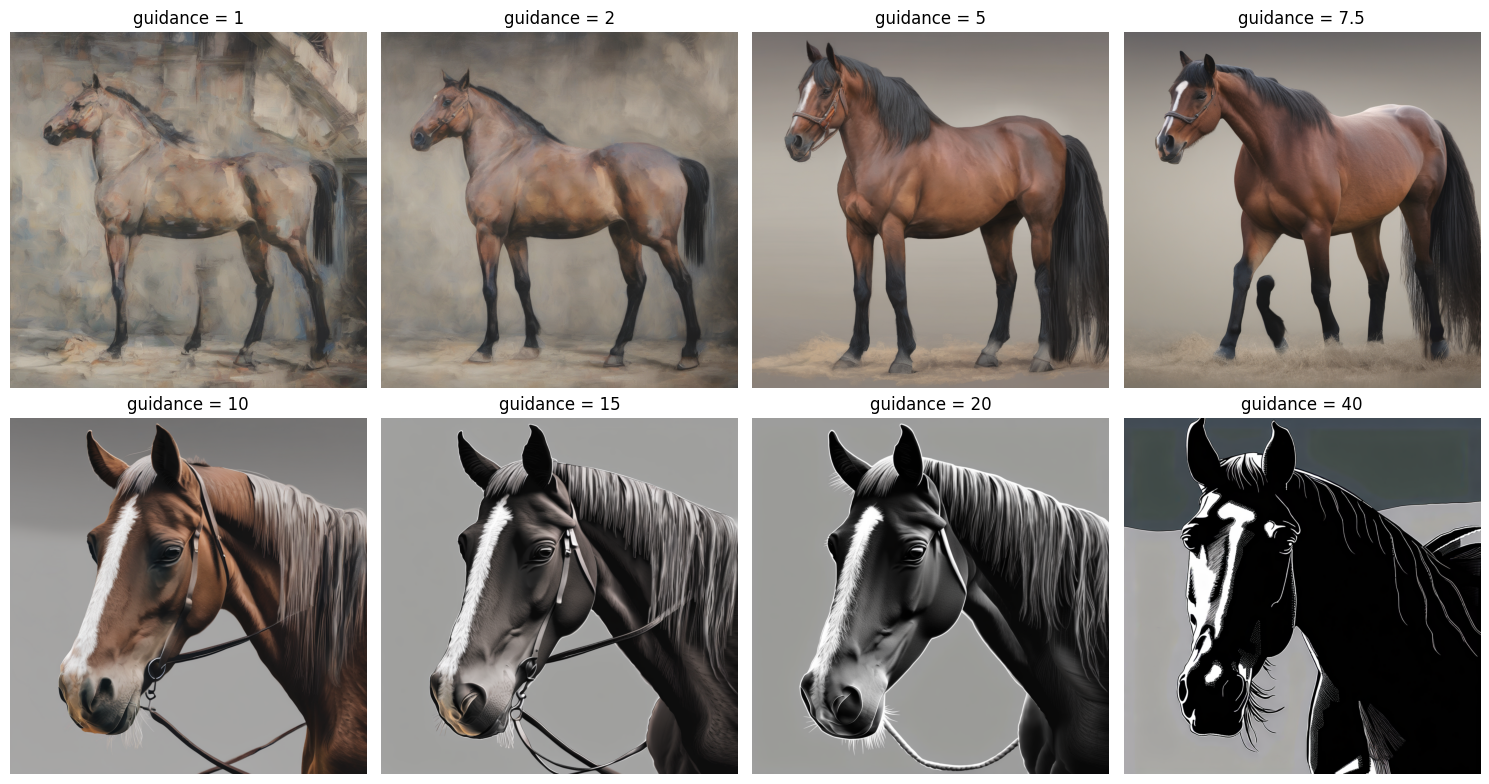

In [ ]:
fig, ax = plt.subplots(2, len(g_grid) // 2, figsize=(15, 8))
ax = ax.ravel()
for i in range(len(g_grid)):
    ax[i].set_title(f"guidance = {g_grid[i]}")
    vis_img(images[i], ax=ax[i])

plt.tight_layout()
plt.show()

In [ ]:
inputs = processor(text=prompt, images=images, return_tensors="pt", padding=True)

In [ ]:
calc_clip_score(inputs)

tensor([0.2940, 0.2894, 0.2857, 0.2804, 0.2783, 0.2851, 0.2876, 0.2711],
       grad_fn=<SumBackward1>)

Теперь посмотрим как ведет себя метрика при более сложном промте, такие промты часто используют на практике для получения "красивых изображений".

In [ ]:
prompt = """A steampunk airship sailing over volcanic clouds, 
painted in classic romanticism landscape style combined with comic book heavy ink outlines, 
rich emotional skies contrasted with bold crisp paneling
"""

In [ ]:
images = list(generate_img(g) for g in g_grid)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

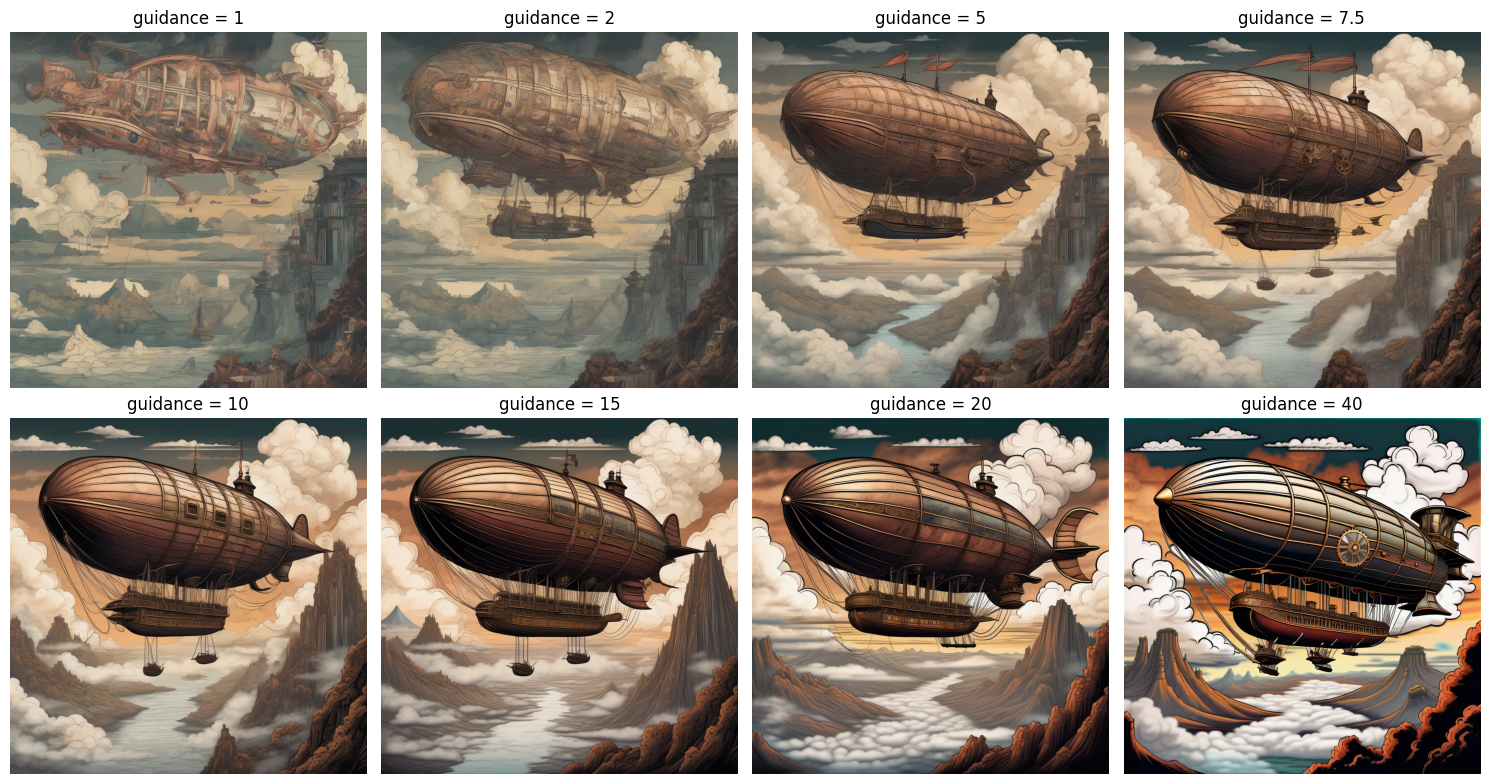

In [ ]:
fig, ax = plt.subplots(2, len(g_grid) // 2, figsize=(15, 8))
ax = ax.ravel()
for i in range(len(g_grid)):
    ax[i].set_title(f"guidance = {g_grid[i]}")
    vis_img(images[i], ax=ax[i])

plt.tight_layout()
plt.show()

In [ ]:
inputs = processor(text="A steampunk airship", images=images, return_tensors="pt", padding=True)
calc_clip_score(inputs)